In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from statistics import *


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [3]:
# create engine to connect to the sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [8]:
# Bind the engine to a session so you can access any of the tables
from sqlalchemy.orm import Session
session = Session(bind=engine)
Measurement

sqlalchemy.ext.automap.measurement

In [9]:
# see https://towardsdatascience.com/sqlalchemy-python-tutorial-79a577141a91
import sqlalchemy as db
engine = db.create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()
metadata = db.MetaData()
m = db.Table('Measurement', metadata, autoload=True, autoload_with=engine)
s = db.Table('Station', metadata, autoload=True, autoload_with=engine)

In [10]:
# Print the column names from each table

print(m.columns.keys())

print(s.columns.keys())


['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [11]:
# Full table metadata

print(repr(metadata.tables['Measurement']))

print("------------")

print(repr(metadata.tables['Station']))

Table('Measurement', MetaData(bind=None), Column('id', INTEGER(), table=<Measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<Measurement>), Column('date', TEXT(), table=<Measurement>), Column('prcp', FLOAT(), table=<Measurement>), Column('tobs', FLOAT(), table=<Measurement>), schema=None)
------------
Table('Station', MetaData(bind=None), Column('id', INTEGER(), table=<Station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<Station>), Column('name', TEXT(), table=<Station>), Column('latitude', FLOAT(), table=<Station>), Column('longitude', FLOAT(), table=<Station>), Column('elevation', FLOAT(), table=<Station>), schema=None)


In [12]:
#Equivalent to 'SELECT * FROM Measurement' (or 'SELECT * FROM Station')
queryM = db.select([Measurement])
queryM

queryS = db.select([Station])
queryS

<sqlalchemy.sql.selectable.Select at 0x21628d014e0; Select object>

In [13]:

ResultProxyM = connection.execute(queryM)

ResultProxyS = connection.execute(queryS)



In [14]:
ResultSetM = ResultProxyM.fetchall()

ResultSetS = ResultProxyS.fetchall()


In [15]:
# 1st 3 lines of Measurement data printed out for viewing
ResultSetM[:3]




[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [16]:
# 1st 3 lines of Station data printed out for viewing
ResultSetS[:3]

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [17]:
# convert to dataframe and drop NaN
M_df = pd.DataFrame(ResultSetM)
M_df.columns = ResultSetM[0].keys()
M_df = M_df.dropna()
M_df.head()

# Eport this to CSV
M_df.to_csv('measurement_cleaned.csv')

In [18]:
# Capture oldest and newest dates
oldest = M_df.iloc[0]['date']
oldest

newest = M_df.iloc[-1]['date']
newest

'2017-08-23'

In [19]:
# convert to dataframe and drop NaN 
S_df = pd.DataFrame(ResultSetS)
S_df.columns = ResultSetS[0].keys()
S_df = S_df.dropna()
S_df.head()

# Export this cleaned Station CSV:
S_df.to_csv('station_cleaned.csv')

# Exploratory Climate Analysis

In [20]:
# Sample query
results1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date < '2018-07')
results1

data = [row[1] for row in results1[:10]]
data

[0.08, 0.0, 0.0, 0.0, None, 0.06, 0.0, 0.0, 0.0, 0.01]

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the date 1 year ago from the last data point in the database
# use the below to find out the latest date in the table which in this case is '2017-08-23'
newest = M_df.iloc[-1]['date']
print(f'The latest date in the set of data points is {newest}.')

# The last date from above 'newest' is '2017-08-23'. Thus the date 1 yr ago is '2018-08-23'.
last_year_date = '2016-08-23'
print('The date 1 yr ago is 2016-08-23.')


The latest date in the set of data points is 2017-08-23.
The date 1 yr ago is 2016-08-23.


In [22]:
# SQLAlchemy ORM functions (pythonic) method to find the last 12 months of precipitation data
results1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23')

# Alternate method to set up the x and y data for the bar chart
# x_data = [row[0] for row in results1[:]]
# y_data = [row[1] for row in results1[:]]

# Save the query results as a Pandas DataFrame 
measurement_ly_df = pd.DataFrame(results1, columns = ['Date', 'Precipitation'])
measurement_ly_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [23]:
# Drop the NaN values and rows with blank cells
measurement_ly_df = measurement_ly_df.dropna()
measurement_ly_df = measurement_ly_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# Sort the dataframe by date
measurement_ly_df = measurement_ly_df.sort_values('Date')
measurement_ly_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


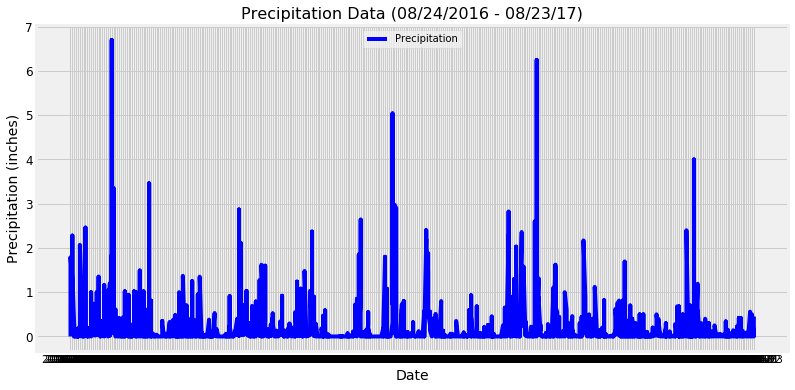

In [24]:
# Pandas Plotting with Matplotlib to plot the  above data
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(measurement_ly_df ['Date'], measurement_ly_df['Precipitation'], color='b')

ax.set_xlabel("Date", size= 14)
ax.set_ylabel('Precipitation (inches)', size = 14)
ax.set_title("Precipitation Data (08/24/2016 - 08/23/17)", size= 16)
plt.yticks(size= 12)
plt.legend(["Precipitation"],loc= 'upper center')
plt.savefig('Precipitation_Data.png', bbox_inches='tight')
plt.show()

![precipitation](Images/precipitation.png)

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data

measurement_ly_df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

![describe](Images/describe.png)

In [26]:
# Station columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
# Design a query to show how many stations are available in this dataset?
data = session.query(func.count(Station.station)).all()

print(f'There are {data} stations available in the dataset. We can also verify this by viewing the entire Station table: ')
S_df


There are [(9,)] stations available in the dataset. We can also verify this by viewing the entire Station table: 


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [27]:
# MOST ACTIVE STATIONS IN DESCENDING ORDER (i.e. what stations have the most rows?):
# List the stations and the counts in descending order (This requires: 'FROM sqlalchemy import desc')
station_and_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
print(f'The most active stations in descending order are as follows:')
station_and_counts

The most active stations in descending order are as follows:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# LOWEST TEMP RECORDED
min_tobs = session.query(func.min(Measurement.tobs)).all()
print(f'The lowest temperature recorded is {min_tobs}.')

# HIGHEST TEMP RECORDED
max_tobs = session.query(func.max(Measurement.tobs)).all()
print(f'The highest temperature recorded is {max_tobs}.')

# AVERAGE TEMP
avg_tobs = session.query(func.avg(Measurement.tobs)).all()
print(f'The avg temperature recorded is {avg_tobs}.')



The lowest temperature recorded is [(53.0,)].
The highest temperature recorded is [(87.0,)].
The avg temperature recorded is [(73.09795396419437,)].


In [29]:
# # find only the most active station 'USC00519281'
most_active = M_df[M_df['station'].str.match('USC00519281')]
most_active.head()



,id,station,date,prcp,tobs
12187,12188,USC00519281,2010-01-01,0.15,70.0
12188,12189,USC00519281,2010-01-02,0.00,62.0
12189,12190,USC00519281,2010-01-03,0.00,74.0
12190,12191,USC00519281,2010-01-04,0.00,75.0
12191,12192,USC00519281,2010-01-05,0.00,74.0


In [30]:
last_12_mo_USC00519281 = session.query(Measurement.station, Measurement.tobs, Measurement.date).filter(Measurement.station =='USC00519281' ).filter(Measurement.date >= '2016-08-01', Measurement.date <= '2017-08-31').all()


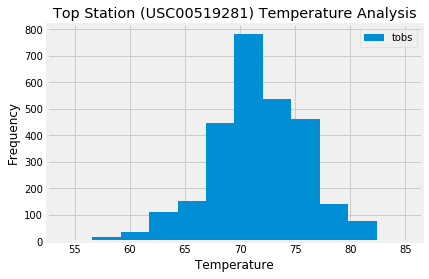

In [31]:

plt.hist(most_active['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Top Station (USC00519281) Temperature Analysis")
plt.legend(["tobs"], loc="best")
plt.savefig("Top_Station_Temp_Analysis.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use `calc_temps` to calc the tmin, tavg, & tmax for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-08-24', '2017-08-23')
print(trip_temps)

trip_temp_min = trip_temps[0][0]
trip_temp_avg = round((trip_temps[0][1]),2)
trip_temp_max = trip_temps[0][2]

start_date = '2016-08-24'
end_date = '2017-08-23'

trip_temps_all = session.query(Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# # find the standard deviation using the stdev() function from the statistics library
trip_temps_stddev = np.std(trip_temps_all)



[(58.0, 74.57894736842105, 87.0)]


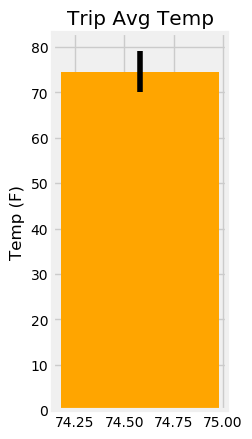

In [34]:
# Plot the results from your previous query as a bar chart. 

w = 2
h = 5
d = 100
plt.figure(figsize=(w, h), dpi=d)
means = (trip_temp_avg)
positions = [trip_temp_avg]
std = (trip_temps_stddev)

plt.bar(positions, means, color="orange", yerr=std)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.savefig('Trip_Avg_Temp.png')
plt.show()

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, Measurement.prcp, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(Measurement.prcp.desc()).all()

# Convert the list of tuples into a dataframe with column headings
rainfall_df = pd.DataFrame(rainfall, columns=['Station', 'prcp', 'lat', 'lon', 'elevation'])
rainfall_df                       

                                                        

,Station,prcp,lat,lon,elevation
0,USC00516128,6.70,21.27160,-157.81680,3.0
1,USC00516128,6.70,21.42340,-157.80150,14.6
2,USC00516128,6.70,21.52130,-157.83740,7.0
3,USC00516128,6.70,21.39340,-157.97510,11.9
4,USC00516128,6.70,21.49920,-158.01110,306.6
5,USC00516128,6.70,21.33556,-157.71139,19.5
6,USC00516128,6.70,21.45167,-157.84889,32.9
7,USC00516128,6.70,21.31520,-157.99920,0.9
8,USC00516128,6.70,21.33310,-157.80250,152.4
9,USC00519523,6.25,21.27160,-157.81680,3.0
